# Part 1: Initial Gene Expression Heatmap in Patients with Pancreatic Cancer

1. Using the two CSV files (datasets/Sophia_PAAD_RNAseq.csv and datasets/Sophia_PAAD_patients.csv), we're looking to create a heatmap of genes of interest with expression in patients.

First step is to remove patients with neuroendocrine and unknown histologies. The selection to be removed has been listed in datasets/paad_tcga_clinical_data.tsv. 

Comments are noted in python with #.

In [1]:
# importing data analysis libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# for reloading libraries and making sure charts and images are displayed
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def remove_patients_from_list(to_remove_file):
    # importing the PAAD patients file (datasets/Sophia_PAAD_patients.csv) as a table in pandas 
    all_paad_patients = pd.read_csv('datasets/Sophia_PAAD_patients.csv', delimiter = ',')
    # importing the patients to be removed (datasets/paad_tcga_clinical_data.csv), only importing
    # the patient ids
    to_remove_list = pd.read_csv(to_remove_file, delimiter = '\t')["Patient ID"]
    # removing patients
    paad_patients = all_paad_patients[~all_paad_patients.submitter_id.isin(to_remove_list)]
    
    return paad_patients

paad_patients = remove_patients_from_list('datasets/paad_tcga_clinical_data.tsv')

paad_patients
# testing to see if the patients were removed, the table should be empty
# paad_patients[paad_patients.submitter_id == 'TCGA-2L-AAQM']

,Cancer_type,submitter_id,PNI,LVI,Extensive PNI,Filename,Diagnosis Age,Sex,Race Category,American Joint Committee on Cancer Tumor Stage Code,Disease Free (Months),Disease Free Status,Neoplasm Disease Stage American Joint Committee on Cancer Code,Neoplasm Histologic Grade,Overall Survival (Months),Overall Survival Status
0,PAAD,TCGA-2J-AAB1,-,1,NaN,caf9cab4-f98f-46bd-a75d-0eb1e9c6c9ea.htseq.cou...,65,Male,WHITE,T3,NaN,NaN,Stage IIB,G3,2.17,DECEASED
1,PAAD,TCGA-2J-AAB4,1,0,1.0,057aa9ac-f22c-4c11-a44d-ad52ae59b4cf.htseq.cou...,48,Male,WHITE,T2,23.95,DiseaseFree,Stage IIB,G2,23.95,LIVING
2,PAAD,TCGA-2J-AAB8,1,1,NaN,03094067-02d4-40c5-b6fa-bb5180dc7eab.htseq.cou...,71,Male,WHITE,T3,2.63,DiseaseFree,Stage IIB,G3,2.63,LIVING
3,PAAD,TCGA-2J-AAB9,1,-,NaN,c19f102d-47a0-48c6-9443-63730d9ea6d1.htseq.cou...,70,Female,WHITE,T3,17.12,Recurred/Progressed,Stage IIB,G1,20.60,DECEASED
4,PAAD,TCGA-2J-AABA,0,0,NaN,c4cadcbb-ae87-43a5-811c-6bedda1d1d8d.htseq.cou...,55,Male,WHITE,T3,15.51,Recurred/Progressed,Stage IIB,G2,19.94,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,PAAD,TCGA-S4-A8RP,1,1,NaN,464c3bd5-5bd2-415f-919e-a5a779a103c4.htseq.cou...,77,Female,WHITE,T3,NaN,NaN,Stage IIB,G3,23.06,DECEASED
150,PAAD,TCGA-US-A779,0,0,NaN,65f1f44c-1f60-45cd-8e1d-16304536c4d5.htseq.cou...,54,Female,WHITE,T3,NaN,NaN,Stage IIB,G1,16.79,DECEASED
151,PAAD,TCGA-XD-AAUG,1,1,1.0,30de5f0b-3c3e-4120-b2bd-9204214341fc.htseq.cou...,66,Female,WHITE,T3,13.80,DiseaseFree,Stage IV,G2,13.80,LIVING
152,PAAD,TCGA-XN-A8T3,1,1,NaN,4cd85f4f-162e-40a8-ab1d-4f6f562c68ff.htseq.cou...,67,Male,WHITE,T2,31.24,DiseaseFree,Stage IB,G2,31.24,LIVING


In [4]:
count_files_list = []
# the filenames column is formatted differently from the column names in the RNASeq table
for file in paad_patients['Filename'].tolist():
    count_files_list.append(file.replace('-', '.'))
    
count_files_list.insert(0, 'hgnc_symbol')

Once the patient table is edited, the RNA seq table can be edited to focus on the neurotransmitter families and the genes that correspond to each of these families.

In [5]:
# take the RNASeq data table to only include genes of interest
all_rnaseq = pd.read_csv('datasets/Sophia_PAAD_RNAseq.csv', delimiter = ',')
neurotransmitter_genes = pd.read_csv('datasets/neurotransmitter_gene_family.csv', delimiter = ',')
rnaseq_goi = all_rnaseq[all_rnaseq['hgnc_symbol'].isin(neurotransmitter_genes["receptor gene"])]

# taking only the counts from paad patients
rnaseq = rnaseq_goi[rnaseq_goi.columns.intersection(count_files_list)]

# sorting the returned table so it's in the same order as neurotransmitter_gene_family.csv
receptor_gene_list = neurotransmitter_genes['receptor gene'].tolist()
rnaseq.loc[:, 'hgnc_symbol'] = pd.Categorical(rnaseq['hgnc_symbol'], categories = receptor_gene_list, ordered = True)
rnaseq = rnaseq.sort_values('hgnc_symbol')

# might come back to deal with this warning? it gets the result for now
pd.options.mode.chained_assignment = None

rnaseq


/Users/sophia2/spring2020/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,hgnc_symbol,a0f5f7d4.88e0.4f3b.853b.e1e4f6bca748.htseq.counts.gz,a19219b1.db59.4493.83ef.e938e2ffdefd.htseq.counts.gz,a2a33be8.232b.44bf.a003.349017a5bc5a.htseq.counts.gz,a995d6ba.19c7.498f.b2d8.3f9b4b4826a1.htseq.counts.gz,aab761be.87c9.41a2.99b8.8bed9032333c.htseq.counts.gz,aec2e0c7.4792.41af.873c.3f3a53ec6d38.htseq.counts.gz,aeeb2bc3.c26d.4988.b4d6.425c7b2db8ae.htseq.counts.gz,b0159d01.f1eb.490d.875b.cfdabed6f529.htseq.counts.gz,b14ad58e.4740.4c4f.83ff.7535efe6a055.htseq.counts.gz,...,e8924790.8df6.40ed.be0d.2c74d8c2d974.htseq.counts.gz,eb3894d4.fcae.43ef.ad68.b756c6aa56ea.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,f748bf78.4dc1.47ad.8611.8186479d3e4b.htseq.counts.gz,f8551a29.d4bd.4954.bf9c.8e10265063de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,feb22766.4282.47c8.bfe2.7d020b4a15d4.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz
6402,DRD1,476,159,82,124,162,299,94,368,62,...,259,48,173,99,239,78,72,127,115,113
6403,DRD2,4343,4879,8926,5257,1521,4788,3731,19820,4604,...,7560,10159,2557,8638,9238,14085,6181,9665,1771,3394
6404,DRD3,1480,1966,1257,1064,884,2638,923,1636,1491,...,1561,1475,1105,1357,1366,1016,795,2165,1472,1364
6405,DRD4,54,100,98,4,9,12,32,78,123,...,95,129,28,126,102,84,38,85,73,153
6406,DRD5,247,258,326,147,323,305,266,398,253,...,379,376,246,158,485,249,333,498,390,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,CHRM1,4802,7801,4565,2232,5045,4608,4429,6134,2780,...,8938,6696,3255,5759,6380,6388,4604,6820,6240,4534
4267,CHRM2,10708,14992,4641,2453,2305,4145,3888,10259,6318,...,8833,4054,2257,4812,6258,6866,3075,6401,2549,4360
4268,CHRM3,758,706,433,497,966,974,555,978,674,...,662,619,502,494,733,770,552,1186,538,600
4271,CHRM4,1229,1700,1461,2930,3571,1893,2208,1591,685,...,1352,2270,1474,729,2581,1783,2244,5239,1790,1448


In [6]:
# a function for creating group labels for matplotlib
# used for displaying neurotransmitter family groups on heatmap

# converting the neurotransmitter dataframe table into a python dict
neuro_genes_dict = {}
for index, row in neurotransmitter_genes.iterrows():
    value = row[0]
    if (value in neuro_genes_dict):
        gene_list = neuro_genes_dict[value]
    else:
        gene_list = []
    gene_list.append(row[1])
    neuro_genes_dict[value] = gene_list
        
        
# not sure if i'm using these two functions anymore lol
def make_groups(neuro_genes_dict):
    try:
        data = neuro_genes_dict.items()
    except:
        return
    
    this_group = []
    groups = []
    for key, value in data:
        new_groups = make_groups(value)
        if new_groups is None:
            this_group.append((key, value))
        else:
            this_group.append((key, len(new_groups[-1])))
            if groups:
                groups = [g + n for n, g in zip(new_groups, groups)]
            else:
                groups = new_groups
    return [this_group] + groups

def label_group_bar(ax, neuro_genes_dict):
    groups = make_groups(neuro_genes_dict)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)

    scale = 1. / ly
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos * scale, ypos)
            pos += rpos
        add_line(ax, pos * scale, ypos)
        ypos -= .1

## Part 1.a Creating the first expression heatmap

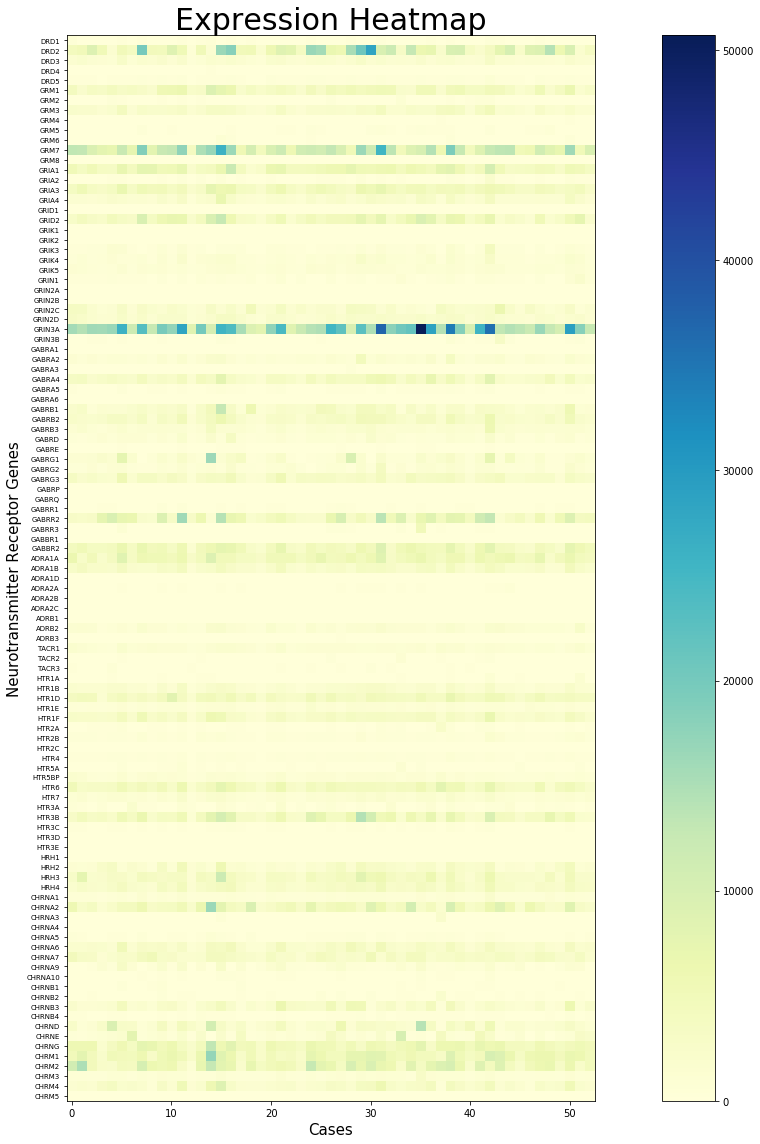

In [7]:
def draw_expression_heatmap(table, y_axis_list):
    # convert this dataframe made with the pandas library to an array that is usable with the numpy
    # library to create heatmap
    htseq_count_values = table.drop('hgnc_symbol', axis=1)
    expression_grid = htseq_count_values.to_numpy(copy=True, dtype=float)
    
    fig, ax = plt.subplots()
    # it's cmap='Blues_r' to change the color scheme
    im = ax.imshow(expression_grid, cmap='YlGnBu')
    
    # show labels for y axis
    ax.set_yticks(np.arange(len(y_axis_list)))
    ax.set_yticklabels(y_axis_list, fontsize=7)
    
    # set labels for axes
    ax.set_ylabel("Neurotransmitter Receptor Genes", fontsize=15)
    ax.set_xlabel("Cases", fontsize=15)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(24, 16)
    
    
    fig.colorbar(im, fraction = 0.046, pad = 0.04)
    
    ax.set_title("Expression Heatmap", fontsize=30, ha='center')
    fig.tight_layout()
    plt.show()
    
    fig.savefig('image/expression_heatmap.png', dpi=100)
    
draw_expression_heatmap(rnaseq, receptor_gene_list)

## Part 1.b Logging the values on the Cancer Expression Heatmap



Here I'm trying out a natural log version of the values in this heatmap, to see if the results are better:



[[4.760e+02 1.590e+02 8.200e+01 ... 1.270e+02 1.150e+02 1.130e+02]
 [4.343e+03 4.879e+03 8.926e+03 ... 9.665e+03 1.771e+03 3.394e+03]
 [1.480e+03 1.966e+03 1.257e+03 ... 2.165e+03 1.472e+03 1.364e+03]
 ...
 [7.580e+02 7.060e+02 4.330e+02 ... 1.186e+03 5.380e+02 6.000e+02]
 [1.229e+03 1.700e+03 1.461e+03 ... 5.239e+03 1.790e+03 1.448e+03]
 [0.000e+00 1.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
[[6.16541785 5.0689042  4.40671925 ... 4.84418709 4.74493213 4.72738782]
 [8.37632063 8.49269556 9.09672365 ... 9.17626639 7.47929964 8.12976445]
 [7.29979737 7.5837563  7.13648321 ... 7.68017564 7.2943773  7.21817684]
 ...
 [6.63068339 6.55961524 6.07073773 ... 7.07834158 6.28785856 6.39692966]
 [7.11395611 7.43838353 7.28687641 ... 8.56388592 7.4899709  7.27793857]
 [      -inf 0.               -inf ...       -inf       -inf       -inf]]


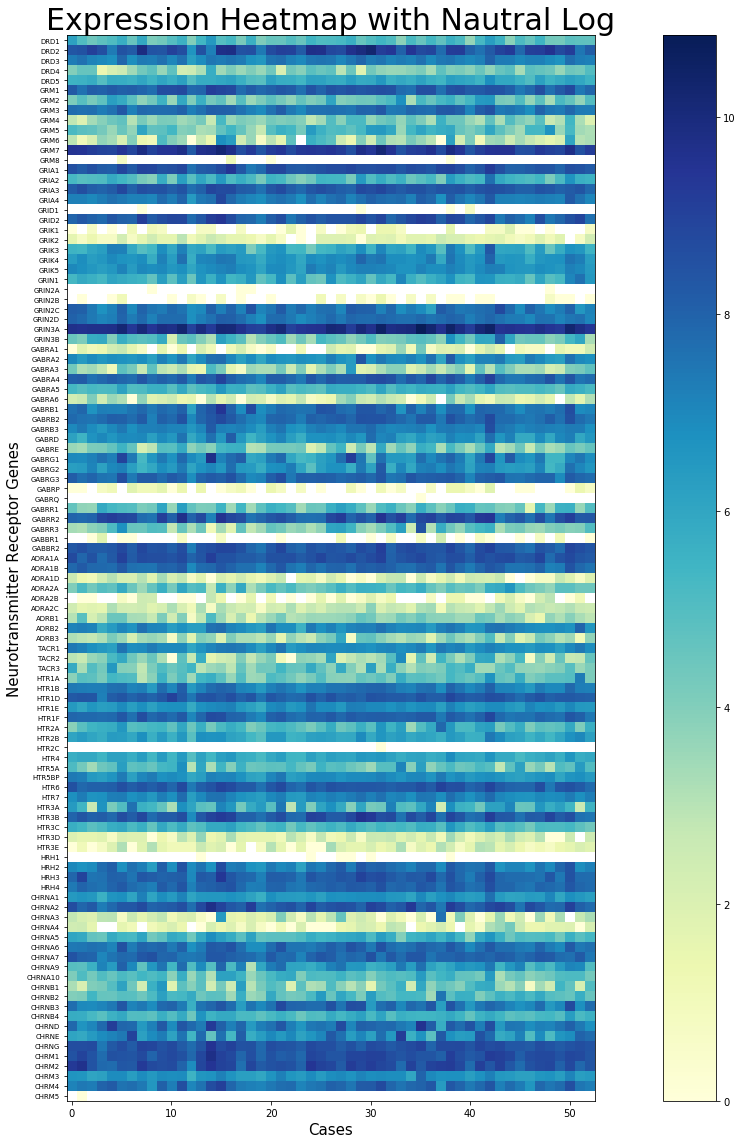

In [8]:
def draw_expression_log_heatmap():
    # convert this dataframe made with the pandas library to an array that is usable with the numpy
    # library to create heatmap
    htseq_count_values = rnaseq.drop('hgnc_symbol', axis=1)
    expression_grid = htseq_count_values.to_numpy(copy=True, dtype=float)
    
    print (expression_grid)
    np.seterr(divide = 'ignore')
    expression_logged = np.log(expression_grid)
    
    print(expression_logged)
    
    fig, ax = plt.subplots()
    # it's cmap='Blues_r' to change the color scheme
    im = ax.imshow(expression_logged, cmap='YlGnBu')
    
    # show labels for y axis
    ax.set_yticks(np.arange(len(receptor_gene_list)))
    ax.set_yticklabels(receptor_gene_list, fontsize=7)
    
    # set labels for axes
    ax.set_ylabel("Neurotransmitter Receptor Genes", fontsize=15)
    ax.set_xlabel("Cases", fontsize=15)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(24, 16)
    
    
    fig.colorbar(im, fraction = 0.046, pad = 0.04)
    
    ax.set_title("Expression Heatmap with Nautral Log", fontsize=30, ha='center')
    fig.tight_layout()
    plt.show()
    
    fig.savefig('image/test.png', dpi=100)
    
draw_expression_log_heatmap()

## Part 1.c Reorganizing the data based on cumulative expression values



Going to try to reorganize the data based on:
Receptor genes (rows) by highest cumulative expression to lowest within each family
Cases (columns) by highest cumulative expression of all the cases


In [9]:
# changing the order of the receptor genes (rows):

rnaseq_columns = list(rnaseq.columns.values)

def sort_table(table):
    # creating a new table for sorting purposes
    rnaseq_with_total = table.copy()
    rnaseq_with_total.loc[:, 'Total by row'] = rnaseq_with_total.sum(axis=1)
    
    # sorting the rows
    rnaseq_sorted = pd.DataFrame(columns=rnaseq_columns)
    # sorts the rows section by section, based on the size of each family of neurotransmitters
    index_begin = 0
    index_end = 0
    appended_data = []
    for family, gene_list in neuro_genes_dict.items():
        index_end = len(gene_list) + index_begin
        to_sort = rnaseq_with_total[index_begin : index_end].sort_values('Total by row')
        appended_data.append(to_sort)
        index_begin = index_end
    # the families were sorted as separate dataframes and then concat together
    rnaseq_sorted = pd.concat(appended_data)
    
    # adding the column sum back in so now we can sort by column
    rnaseq_sorted_2 = rnaseq_sorted.to_numpy(copy=True)
    rnaseq_sorted = pd.DataFrame(rnaseq_sorted_2)
    
    rnaseq_columns.append('Total by row')
    rnaseq_sorted.columns = rnaseq_columns
    rnaseq_sorted.loc['Total by col', :] = rnaseq_with_total.sum(axis=0)
    rnaseq_columns.remove('Total by row')
    
    # sorting the columns:
    
    # remove hgnc_symbol column, sort the values, and then remove the total col and total row   
    excluded = rnaseq_sorted.loc[:, 'hgnc_symbol']
    del rnaseq_sorted['hgnc_symbol']
    sorted_cases = rnaseq_sorted.sort_values('Total by col', axis=1, ascending=True)
    rnaseq_sorted = pd.concat([excluded.rename('hgnc_symbol'), sorted_cases], axis=1)
    rnaseq_sorted.drop('Total by col', axis=0, inplace=True)
    rnaseq_sorted.drop('Total by row', axis=1, inplace=True)
    return rnaseq_sorted

sort_table(rnaseq)


,hgnc_symbol,b6aa34d6.2b02.4317.8361.79536c7cb4e6.htseq.counts.gz,c19f102d.47a0.48c6.9443.63730d9ea6d1.htseq.counts.gz,c642e018.f0cb.4be8.9b19.c944f1daf9cf.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,e75c2077.0098.42b5.ba41.181a768478de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz,a995d6ba.19c7.498f.b2d8.3f9b4b4826a1.htseq.counts.gz,...,b4ce6dd3.35a8.4261.b4d2.a2ab39957593.htseq.counts.gz,bb15d7d0.8705.49af.89e4.fc13c01de642.htseq.counts.gz,cde0617f.fcd6.4c58.b3cf.dcfabc6fcda7.htseq.counts.gz,dbcad16f.6837.4825.af8d.c60cfbcefe1a.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,b7971446.9682.4b03.b469.797d5efb2412.htseq.counts.gz,d42d7f7b.1ba5.4ba5.8af2.35755fef2d69.htseq.counts.gz,e38e0ced.093c.44e9.9f3b.7cdd0e6b912e.htseq.counts.gz,e7cc80ef.4b87.47d9.bebe.1fb05b5b04a2.htseq.counts.gz,b9ab7393.4abb.41ec.9d55.a3dc846c4a93.htseq.counts.gz
0,DRD4,12,36,51,28,47,38,126,153,4,...,10,62,6,63,85,314,43,55,42,32
1,DRD1,54,59,95,173,39,72,99,113,124,...,260,204,100,93,127,630,229,276,545,145
2,DRD5,146,135,218,246,373,333,158,246,147,...,498,461,336,459,498,323,676,522,891,387
3,DRD3,546,679,1056,1105,1084,795,1357,1364,1064,...,1997,1842,2708,2006,2165,1736,1794,1851,3031,1518
4,DRD2,753,1607,3603,2557,3203,6181,8638,3394,5257,...,5449,18284,20776,6372,9665,1334,9553,9562,3782,16597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,CHRNA7,1660,1642,1240,2136,2732,2250,2748,1709,1156,...,1776,3219,2245,4074,2098,4111,1760,2752,2646,4069
103,CHRNA2,2188,2037,2788,1801,2594,2546,6278,2365,1487,...,5240,4023,2872,2692,8456,16442,6293,10085,6459,7857
104,CHRNG,2261,2449,3358,4109,4477,3568,3620,4635,1653,...,3660,8198,3097,7803,4680,13151,5239,6226,5839,5934
105,CHRM1,2547,2545,2523,3255,3711,4604,5759,4534,2232,...,4983,6521,7358,4444,6820,17179,8170,9021,10003,8481


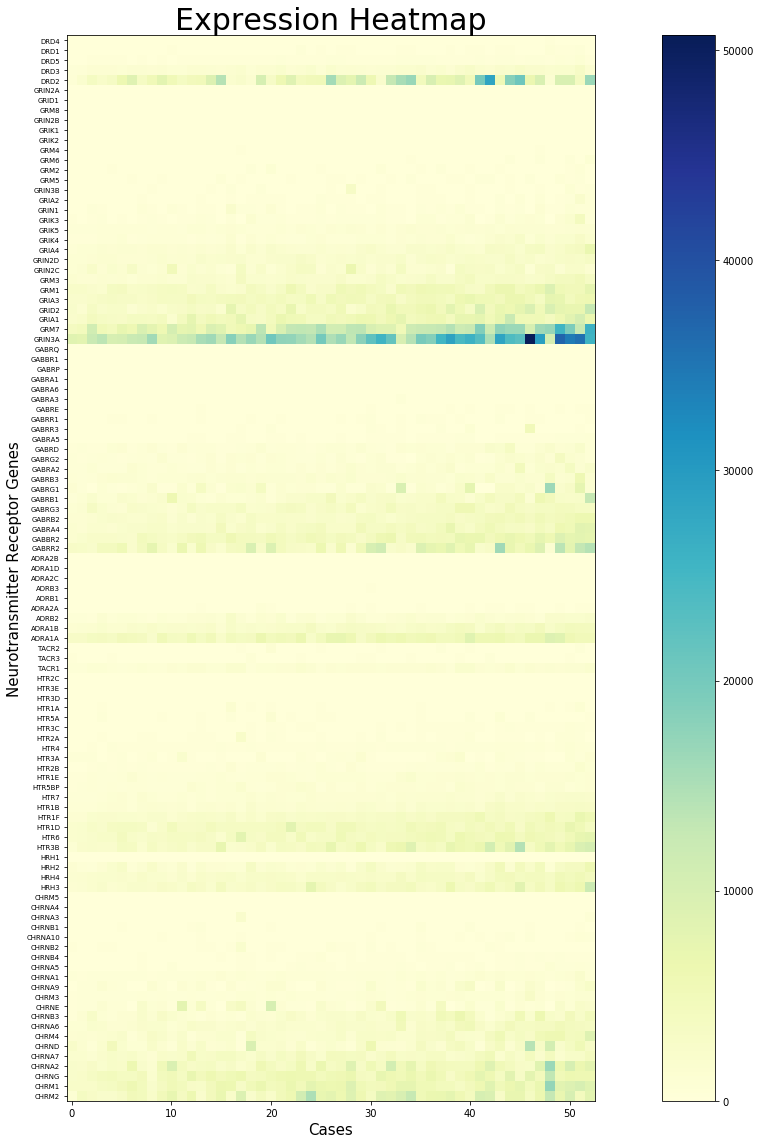

In [10]:
rnaseq_sorted = sort_table(rnaseq)
draw_expression_heatmap(rnaseq_sorted, rnaseq_sorted['hgnc_symbol'].tolist())

## Part 1.d Scaling the heatmap from Part 1.a

Scaling the data to be from 0 to 1 so it might be easier to visualize

In [11]:
def scale_data(table):
    scaled_table = table.copy()
    excluded = scaled_table.loc[:, 'hgnc_symbol']
    scaled_table.drop('hgnc_symbol', axis=1, inplace=True)
    max_value = scaled_table.max().max()
    
    scaled_table = scaled_table/max_value
    
    full_scaled_table = pd.concat([excluded.rename('hgnc_symbol'), scaled_table], axis=1)
    
    return full_scaled_table

scale_data(rnaseq)


,hgnc_symbol,a0f5f7d4.88e0.4f3b.853b.e1e4f6bca748.htseq.counts.gz,a19219b1.db59.4493.83ef.e938e2ffdefd.htseq.counts.gz,a2a33be8.232b.44bf.a003.349017a5bc5a.htseq.counts.gz,a995d6ba.19c7.498f.b2d8.3f9b4b4826a1.htseq.counts.gz,aab761be.87c9.41a2.99b8.8bed9032333c.htseq.counts.gz,aec2e0c7.4792.41af.873c.3f3a53ec6d38.htseq.counts.gz,aeeb2bc3.c26d.4988.b4d6.425c7b2db8ae.htseq.counts.gz,b0159d01.f1eb.490d.875b.cfdabed6f529.htseq.counts.gz,b14ad58e.4740.4c4f.83ff.7535efe6a055.htseq.counts.gz,...,e8924790.8df6.40ed.be0d.2c74d8c2d974.htseq.counts.gz,eb3894d4.fcae.43ef.ad68.b756c6aa56ea.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,f748bf78.4dc1.47ad.8611.8186479d3e4b.htseq.counts.gz,f8551a29.d4bd.4954.bf9c.8e10265063de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,feb22766.4282.47c8.bfe2.7d020b4a15d4.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz
6402,DRD1,0.009388,0.003136,0.001617,0.002446,0.003195,0.005897,0.001854,0.007258,0.001223,...,0.005108,0.000947,0.003412,0.001953,0.004714,0.001538,0.001420,0.002505,0.002268,0.002229
6403,DRD2,0.085656,0.096227,0.176045,0.103682,0.029998,0.094432,0.073585,0.390904,0.090803,...,0.149104,0.200363,0.050431,0.170365,0.182198,0.277794,0.121906,0.190620,0.034929,0.066939
6404,DRD3,0.029190,0.038775,0.024791,0.020985,0.017435,0.052028,0.018204,0.032266,0.029407,...,0.030787,0.029091,0.021794,0.026764,0.026941,0.020038,0.015680,0.042700,0.029032,0.026902
6405,DRD4,0.001065,0.001972,0.001933,0.000079,0.000178,0.000237,0.000631,0.001538,0.002426,...,0.001874,0.002544,0.000552,0.002485,0.002012,0.001657,0.000749,0.001676,0.001440,0.003018
6406,DRD5,0.004872,0.005088,0.006430,0.002899,0.006370,0.006015,0.005246,0.007850,0.004990,...,0.007475,0.007416,0.004852,0.003116,0.009566,0.004911,0.006568,0.009822,0.007692,0.004852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,CHRM1,0.094708,0.153857,0.090034,0.044021,0.099501,0.090882,0.087352,0.120979,0.054829,...,0.176281,0.132063,0.064197,0.113583,0.125831,0.125989,0.090803,0.134509,0.123070,0.089423
4267,CHRM2,0.211191,0.295683,0.091533,0.048380,0.045461,0.081751,0.076682,0.202335,0.124608,...,0.174211,0.079956,0.044514,0.094906,0.123425,0.135416,0.060647,0.126245,0.050273,0.085991
4268,CHRM3,0.014950,0.013924,0.008540,0.009802,0.019052,0.019210,0.010946,0.019289,0.013293,...,0.013056,0.012208,0.009901,0.009743,0.014457,0.015186,0.010887,0.023391,0.010611,0.011834
4271,CHRM4,0.024239,0.033529,0.028815,0.057788,0.070430,0.037335,0.043548,0.031379,0.013510,...,0.026665,0.044771,0.029071,0.014378,0.050904,0.035166,0.044258,0.103327,0.035304,0.028558


### Plotting the scaled data, without reorganization from 1.c:

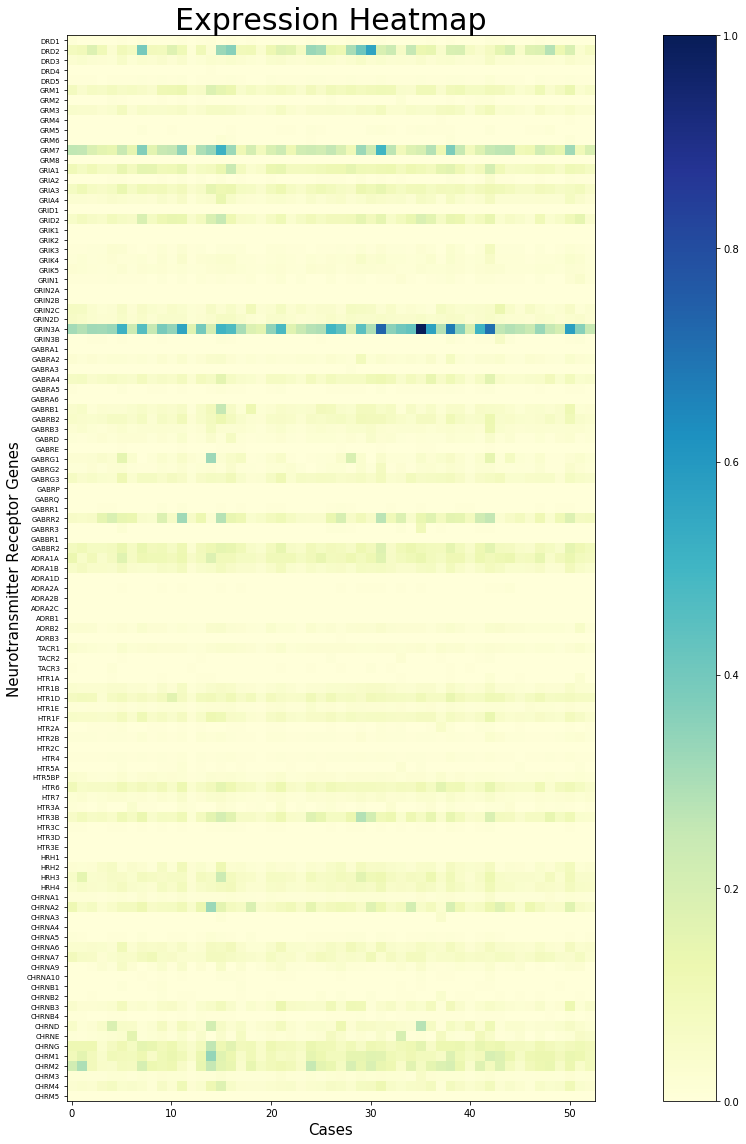

In [12]:
rnaseq_scaled = scale_data(rnaseq)
draw_expression_heatmap(rnaseq_scaled, rnaseq_scaled['hgnc_symbol'].tolist())

### Plotting the scaled data, with reorganization from 1.c:

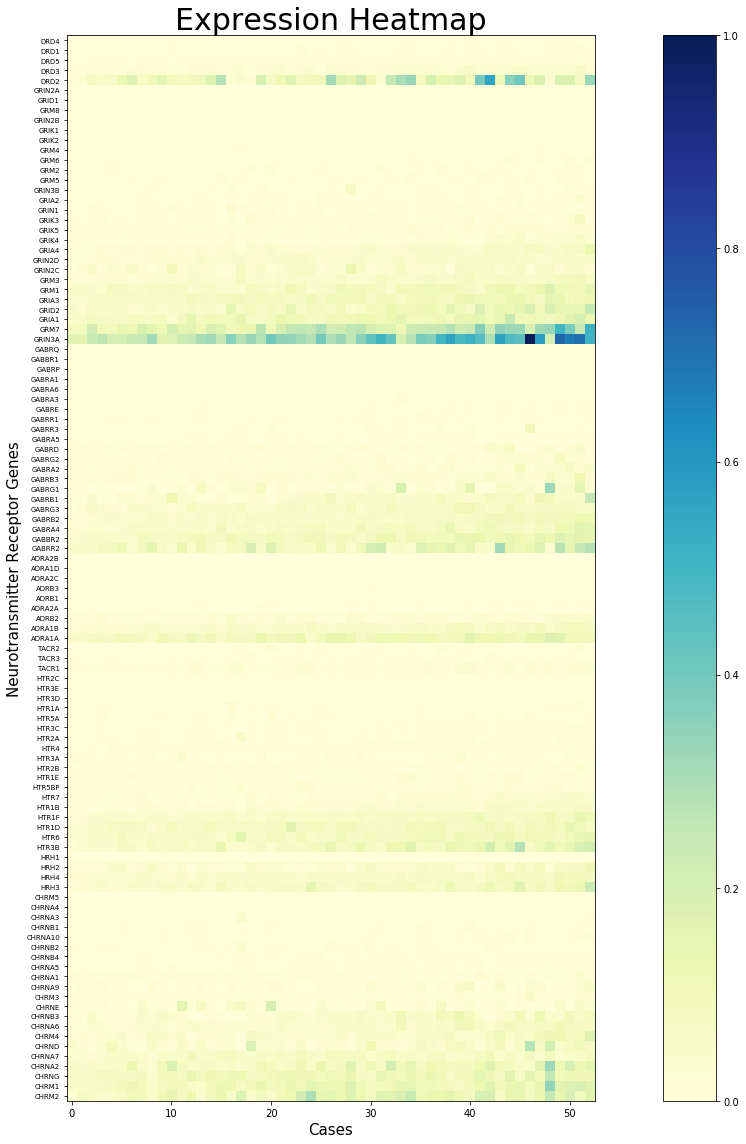

In [13]:
rnaseq_scaled_sorted = sort_table(rnaseq_scaled)
draw_expression_heatmap(rnaseq_scaled_sorted, rnaseq_scaled_sorted['hgnc_symbol'].tolist())

# Part 3: Gene Expression Heatmap with Neurotransmitter Families in Patients with Pancreatic Cancer

In this part, we will group the receptor genes by the neurotransmitter they correspond to and show the expression levels of the neurtransmitter families against our patient cohort.

In [14]:
# we're starting off by adding the expression levels of each of the individual genes for each 
# family

# creating a new dataframe to store values per family
def add_expression_by_family():
    data = []
    for case in rnaseq_columns:
        case_dict = []
        for family, gene_list in neuro_genes_dict.items():
            value = 0
            if (case == 'hgnc_symbol'):
                case_dict.append(family)
                continue
            for gene in gene_list:
                value = rnaseq.loc[rnaseq.hgnc_symbol == gene, case].values[0] + value
            case_dict.append(float(value))     
        data.append(case_dict)
    return data


    

In [15]:
expression_by_family = pd.DataFrame(add_expression_by_family())
expression_by_family = expression_by_family.transpose()
expression_by_family.columns = rnaseq_columns

expression_by_family

,hgnc_symbol,a0f5f7d4.88e0.4f3b.853b.e1e4f6bca748.htseq.counts.gz,a19219b1.db59.4493.83ef.e938e2ffdefd.htseq.counts.gz,a2a33be8.232b.44bf.a003.349017a5bc5a.htseq.counts.gz,a995d6ba.19c7.498f.b2d8.3f9b4b4826a1.htseq.counts.gz,aab761be.87c9.41a2.99b8.8bed9032333c.htseq.counts.gz,aec2e0c7.4792.41af.873c.3f3a53ec6d38.htseq.counts.gz,aeeb2bc3.c26d.4988.b4d6.425c7b2db8ae.htseq.counts.gz,b0159d01.f1eb.490d.875b.cfdabed6f529.htseq.counts.gz,b14ad58e.4740.4c4f.83ff.7535efe6a055.htseq.counts.gz,...,e8924790.8df6.40ed.be0d.2c74d8c2d974.htseq.counts.gz,eb3894d4.fcae.43ef.ad68.b756c6aa56ea.htseq.counts.gz,f144de50.6126.4912.9c94.824d1eb0fac5.htseq.counts.gz,f2389819.b8fc.460e.821c.01dba313cce1.htseq.counts.gz,f748bf78.4dc1.47ad.8611.8186479d3e4b.htseq.counts.gz,f8551a29.d4bd.4954.bf9c.8e10265063de.htseq.counts.gz,f9f63982.b0ee.4cb8.8de5.f885d82137f0.htseq.counts.gz,fcd43085.7338.43fe.bc25.9d87b04e227f.htseq.counts.gz,feb22766.4282.47c8.bfe2.7d020b4a15d4.htseq.counts.gz,fef65b57.c58d.4050.8de4.f09f5cd616ce.htseq.counts.gz
0,dopamine,6600,7362,10689,6596,2899,8042,5046,22300,6533,...,9854,12187,4109,10378,11430,15512,7419,12540,3821,5270
1,glutamate,57109,54335,49724,43556,50664,74837,40547,80044,47529,...,60950,52074,37076,36885,59439,42291,37717,84201,54039,40765
2,GABA,22733,22734,19621,25048,29471,41067,23326,27286,19687,...,22915,22633,16915,16815,26646,20598,18801,44560,23618,20751
3,adrenergics,10337,8206,8788,5349,7024,13971,6522,9943,8644,...,11654,10756,7065,7534,11176,4672,7368,12204,9869,6597
4,tachykinins,2047,1352,1088,789,1379,2307,1078,1067,1729,...,1172,998,1047,684,1031,915,665,1229,1655,1086
5,serotonin,21099,20369,17674,15428,18721,28572,18359,27485,15654,...,21628,17920,13796,15835,22816,19610,18172,27080,19934,14729
6,histamine,5441,11266,4979,6295,9070,7618,6185,7400,5427,...,6098,6059,5458,4735,6604,7555,6396,13447,5946,5965
7,cholinergic,42230,42418,30146,20968,35823,42595,36508,44897,33077,...,45411,33612,23444,29276,38995,32081,25275,52228,32965,28606


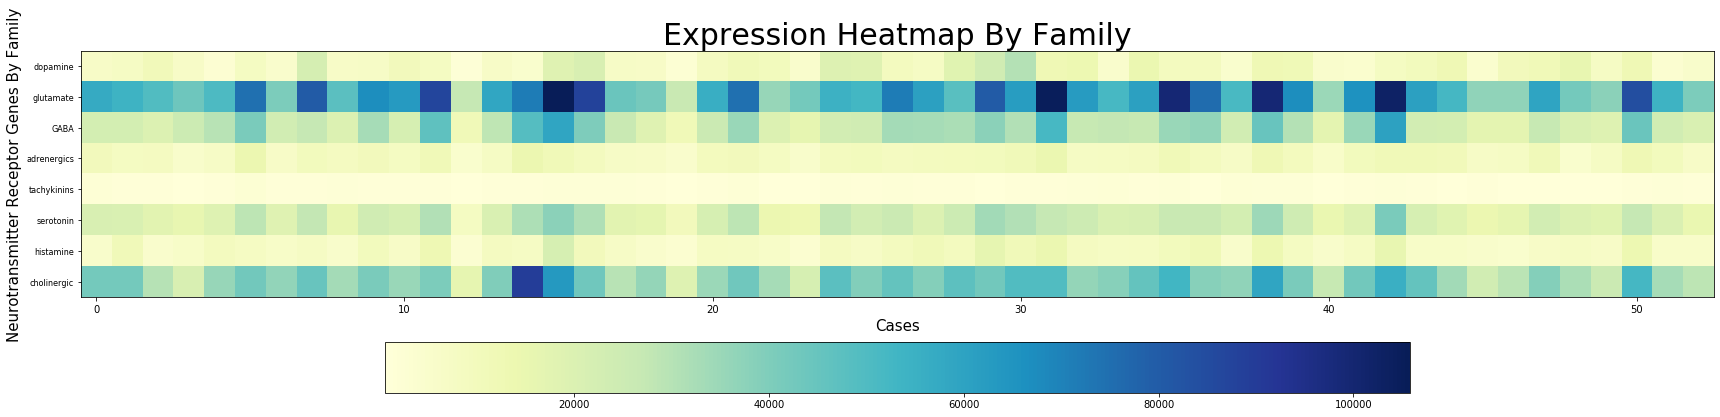

In [16]:
def draw_expression_by_family():

    # convert the pandas dataframe to a numpy array
    htseq_count_by_family = expression_by_family.drop('hgnc_symbol', axis=1)
    expression_grid_by_family = htseq_count_by_family.to_numpy(copy=True, dtype=float)

    fig, ax = plt.subplots()
    im = ax.imshow(expression_grid_by_family, cmap="YlGnBu")

    # show labels for y axis
    ax.set_yticks(np.arange(len(neuro_genes_dict.keys())))
    ax.set_yticklabels(neuro_genes_dict.keys(), fontsize=8)

    # set labels for axes
    ax.set_ylabel("Neurotransmitter Receptor Genes By Family", fontsize=15)
    ax.set_xlabel("Cases", fontsize=15)
    
    # resizing the graph
    fig = plt.gcf()
    fig.set_size_inches(24, 16)


    fig.colorbar(im, fraction = 0.046, pad = 0.04, orientation = 'horizontal')

    ax.set_title("Expression Heatmap By Family", fontsize=30, ha='center')
    fig.tight_layout()
    plt.show()

    #fig_by_family.savefig('image/byfamily.png', dpi=100)
    
    
draw_expression_by_family()